# TIME introduction

## Getting started

- Reproduce file structure from Ilias (remember to unzip data):
```text
TIME
|-- data
    |-- condition-monitoring-of-hydraulic-systems
    |-- GlobalLandTemperaturesByCountry.csv
    |-- victoria_electricity_demand.csv
|-- notebooks
    |-- 01_TIME_introduction.ipynb
    |-- data.py
    |-- utils.py
|-- requirements.txt
```
- Setup and activate virtual environment ([tutorial](https://realpython.com/python-virtual-environments-a-primer/))
- Install requirements: `pip install -r requirements.txt`
- Within the `TIME` directory, start the jupyter server: `jupyter notebook`
- Run notebook

In [1]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from utils import get_figure, time_plot
from data import get_electrocardiogram, get_apple_5y, get_france_death_rate_20y, get_switzerland_temperature, get_sensor_data

## Time series exemples

### Time series in healthcare

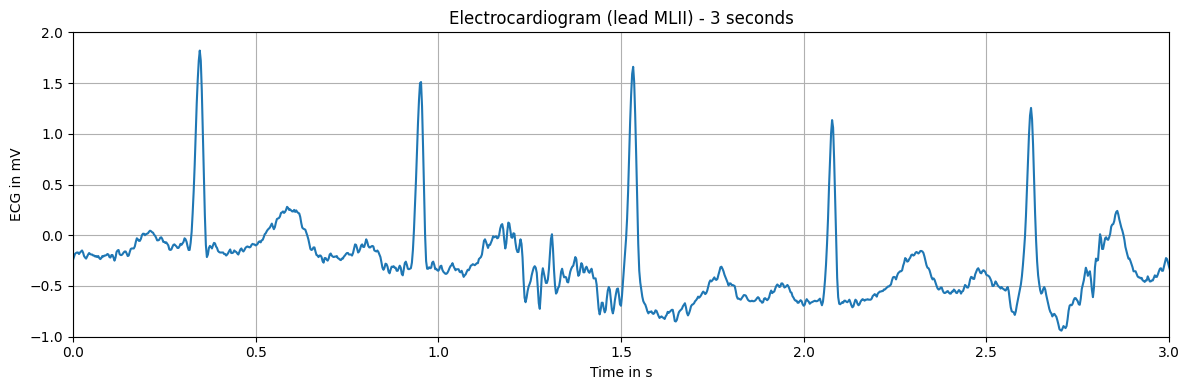

In [2]:
data = get_electrocardiogram()
time_plot(
    x=data['time'],
    y=data['ecg'],
    title='Electrocardiogram (lead MLII) - 3 seconds',
    xlabel='Time in s',
    ylabel='ECG in mV',
    xlim=(0,3),
    ylim=(-1,2),
)

### Time series in finance

/home/david/git/HSLU.Time/notebooks/data.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed


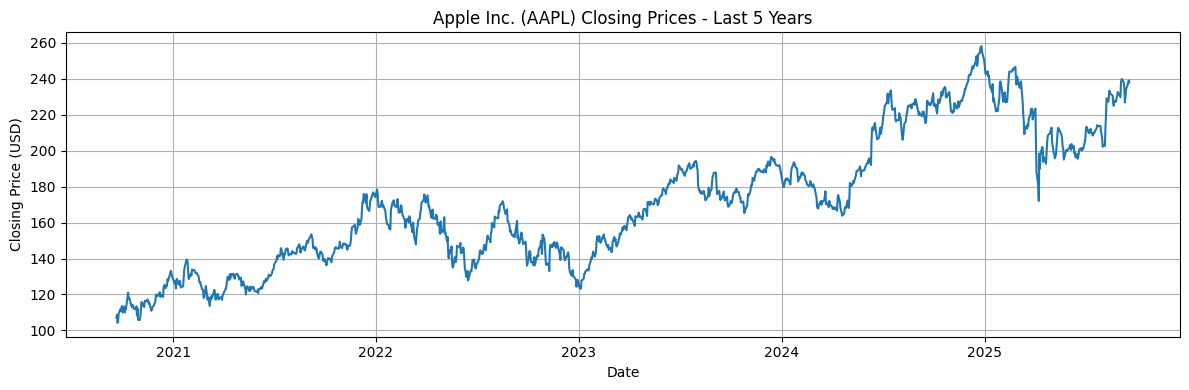

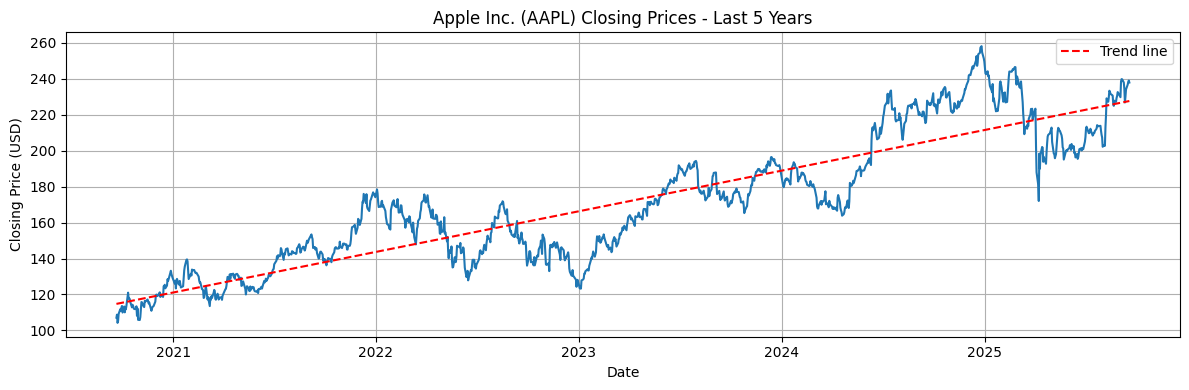

In [3]:
data = get_apple_5y()
time_plot(
    x=data.index,
    y=data['Close'],
    title='Apple Inc. (AAPL) Closing Prices - Last 5 Years',
    xlabel='Date',
    ylabel='Closing Price (USD)',
)

time_plot(
    x=data.index,
    y=data['Close'],
    title='Apple Inc. (AAPL) Closing Prices - Last 5 Years',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    show_trend=True
)

### Time series in demographics

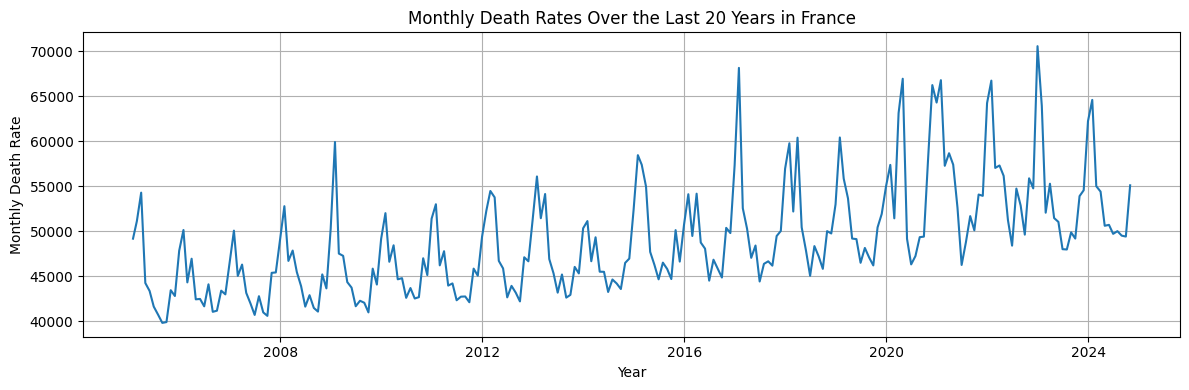

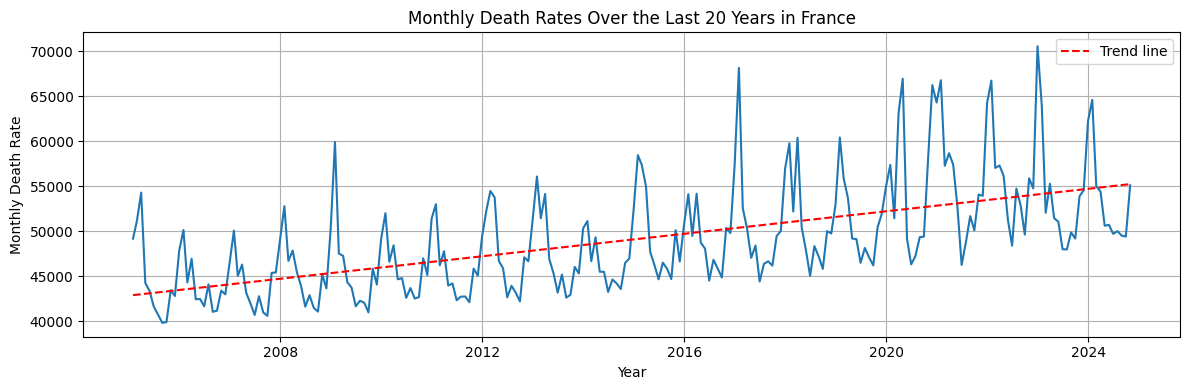

In [4]:
data = get_france_death_rate_20y()
time_plot(
    x=data['time'],
    y=data['value'],
    title='Monthly Death Rates Over the Last 20 Years in France',
    xlabel='Year',
    ylabel='Monthly Death Rate',
)
time_plot(
    x=data['time'],
    y=data['value'],
    title='Monthly Death Rates Over the Last 20 Years in France',
    xlabel='Year',
    ylabel='Monthly Death Rate',
    show_trend=True
)

### Time series in meteorology

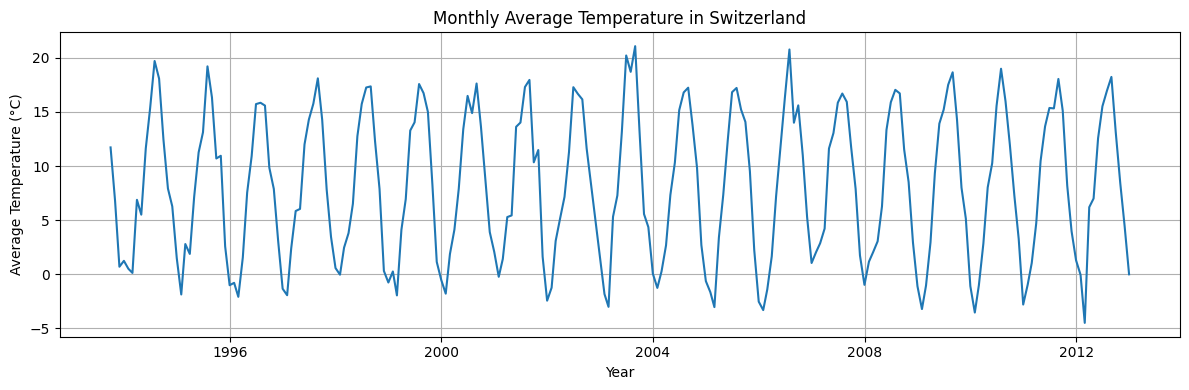

In [5]:
data = get_switzerland_temperature()
time_plot(
    x=data['dt'],
    y=data['AverageTemperature'],
    title='Monthly Average Temperature in Switzerland',
    xlabel='Year',
    ylabel='Average Temperature (°C)',
)

### Time series in industry

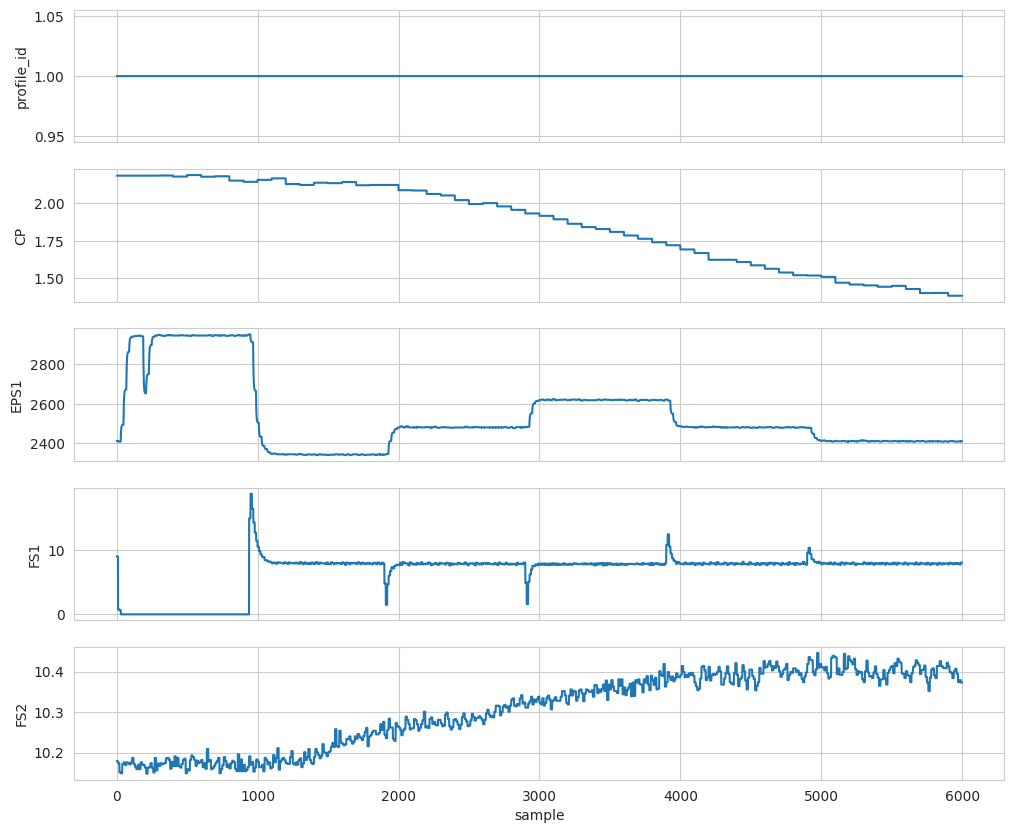

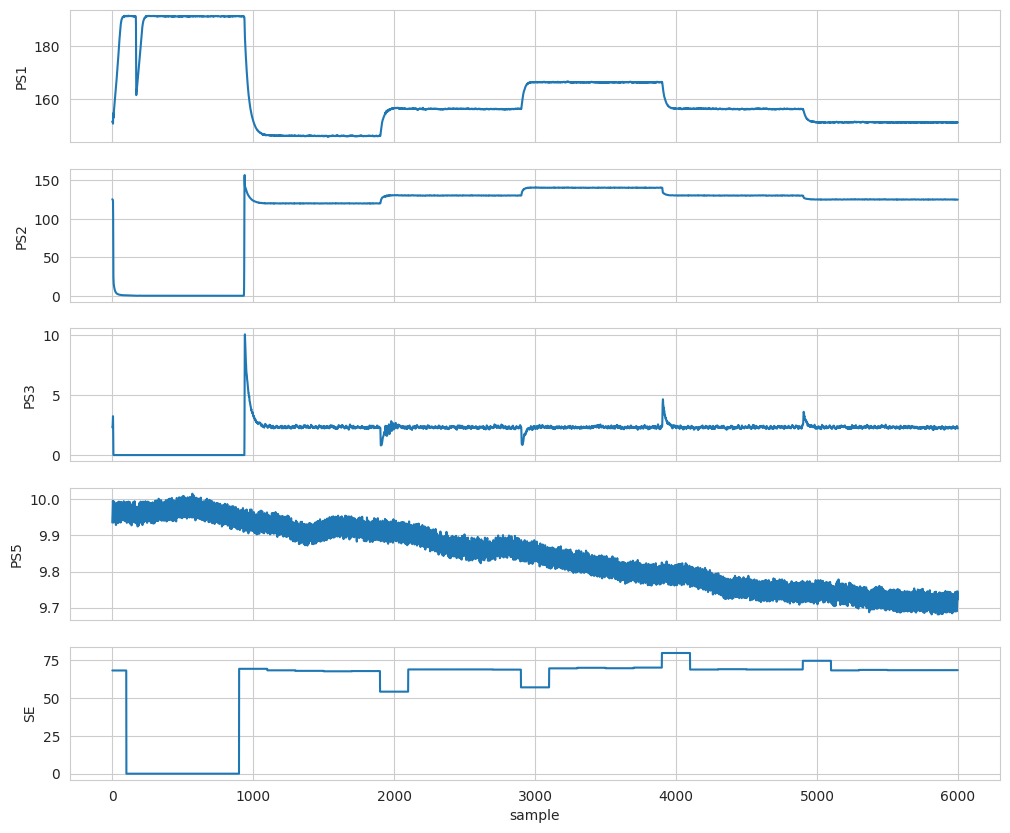

In [6]:
def plot_profile(df: pd.DataFrame, profile_id: int, features: List[str] = []):
    filtered_df = df[features][df.profile_id == profile_id].reset_index()
    with sns.axes_style("whitegrid"):
        fig, axs = get_figure(nrows=len(features), ncols=1, figsize=(12, len(features)*2), sharex=True)
        plt.xlabel("sample")
        for ax, feature_name in zip(axs, features):
            ax.plot(filtered_df[feature_name])
            ax.set_ylabel(feature_name)

data = get_sensor_data()
data = data[[c for c in data.columns if c not in ["CE", "PS4", "PS6"]]]
plot_profile(data, profile_id=1, features=data.columns[:5])
plot_profile(data, profile_id=1, features=data.columns[5:10])

## Challenge of time dependence

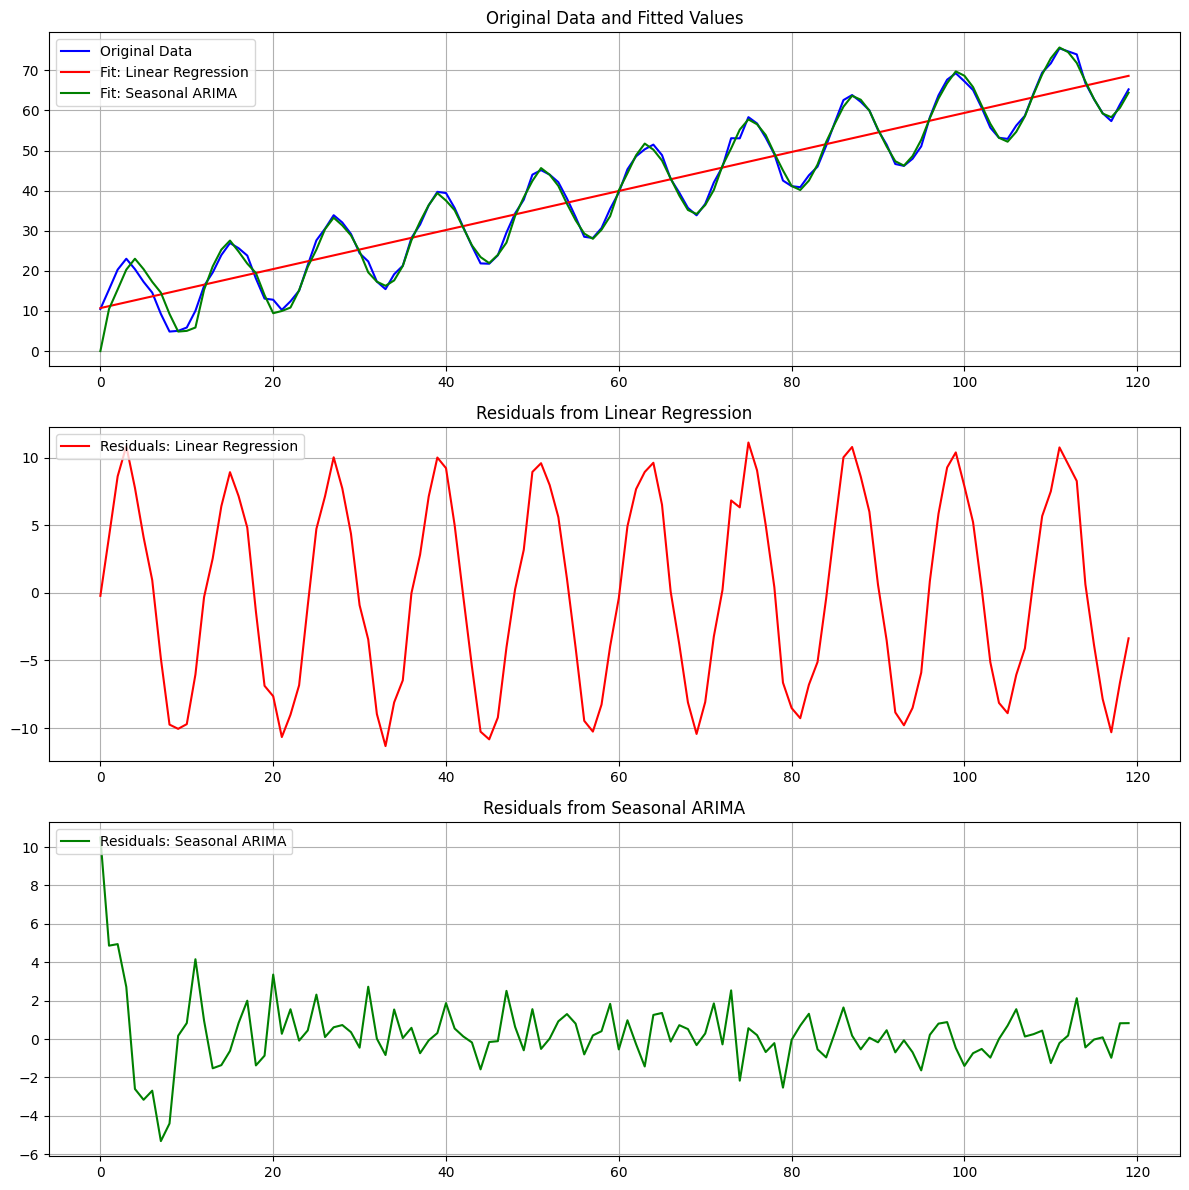

In [7]:
np.random.seed(42)
n = 120
t = np.arange(n)
data = 10 + 0.5 * t + 10 * np.sin(2 * np.pi * t / 12) + np.random.normal(size=n)

X = sm.add_constant(t)
model_simple = sm.OLS(data, X).fit()
data_pred_simple = model_simple.predict(X)
residuals_simple = data - data_pred_simple

model_arima = ARIMA(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_arima = model_arima.fit()
data_pred_arima = results_arima.predict()
residuals_arima = data - data_pred_arima

fig, [ax1, ax2, ax3] = get_figure(nrows=3, ncols=1, figsize=(12, 12))
ax1.plot(data, label='Original Data', color='blue')
ax1.plot(data_pred_simple, label='Fit: Linear Regression', color='red')
ax1.plot(data_pred_arima, label='Fit: Seasonal ARIMA', color='green')
ax1.set_title('Original Data and Fitted Values')
ax1.legend(loc="upper left")

ax2.plot(residuals_simple, label='Residuals: Linear Regression', color='red')
ax2.set_title('Residuals from Linear Regression')
ax2.legend(loc="upper left")

ax3.plot(residuals_arima, label='Residuals: Seasonal ARIMA', color='green')
ax3.set_title('Residuals from Seasonal ARIMA')
ax3.legend(loc="upper left")

fig.tight_layout()

## Visualization of time series

### Seasonal Plot

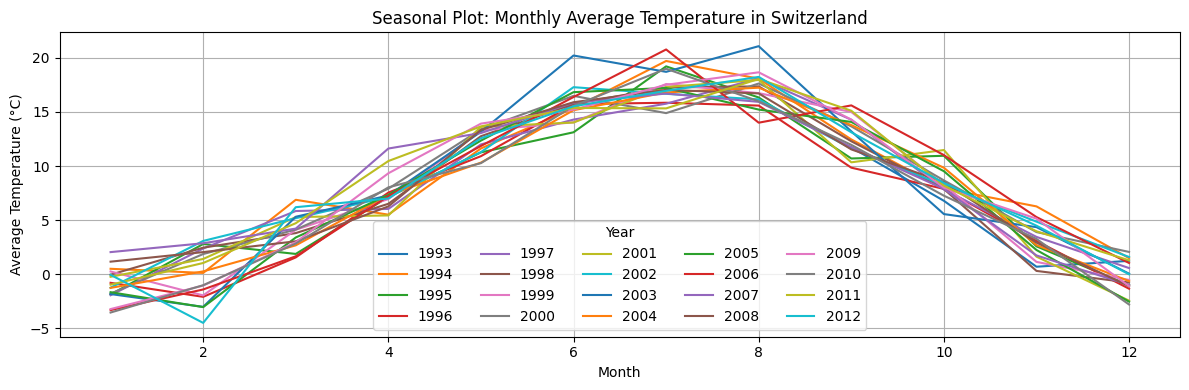

In [8]:
df = get_switzerland_temperature()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month'] = df['dt'].dt.month
df['Year'] = df['dt'].dt.year
pivot_df = df.pivot(index='Month', columns='Year', values='AverageTemperature')
fig, [ax] = get_figure()
for year in pivot_df.columns:
    ax.plot(pivot_df.index, pivot_df[year], label=year)

ax.set_title('Seasonal Plot: Monthly Average Temperature in Switzerland')
ax.set_xlabel('Month')
ax.set_ylabel('Average Temperature (°C)')
ax.legend(title='Year', loc='lower center', ncol=5)
fig.tight_layout()

### Seasonal Boxplot

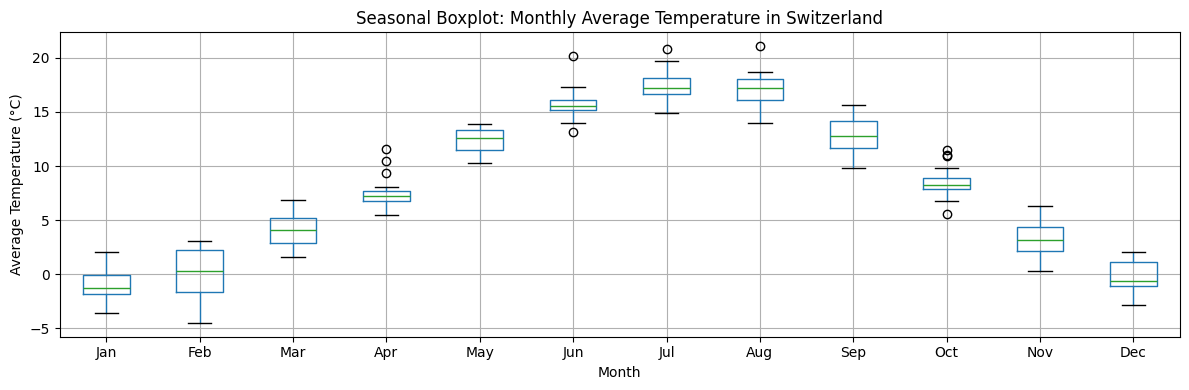

In [9]:
boxplot_df = df.pivot(index='Year', columns='Month', values='AverageTemperature')
fig, [ax] = get_figure()
boxplot_df.boxplot(ax=ax)
ax.set_title('Seasonal Boxplot: Monthly Average Temperature in Switzerland')
ax.set_xlabel('Month')
ax.set_ylabel('Average Temperature (°C)')
ax.set_xticks(ticks=range(1, 13), labels=months)
fig.tight_layout()

### Calendar Heatmap

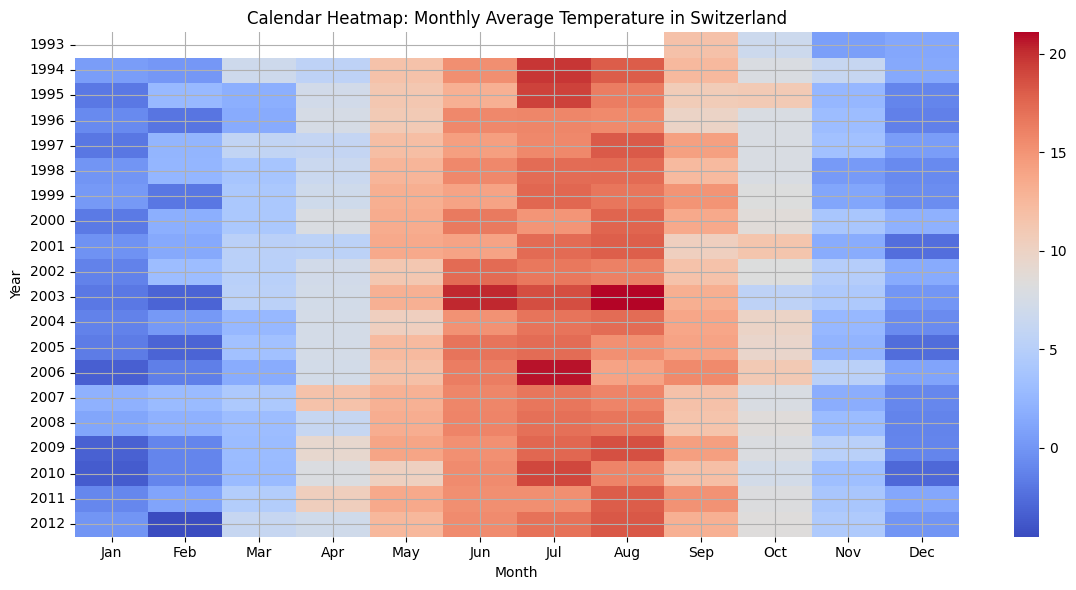

In [10]:
fig, [ax] = get_figure(figsize=(12, 6))
sns.heatmap(boxplot_df, ax=ax, cmap="coolwarm", annot=False, cbar=True, xticklabels=months)
ax.set_title('Calendar Heatmap: Monthly Average Temperature in Switzerland')
ax.set_xlabel('Month')
ax.set_ylabel('Year')
fig.tight_layout()

### Seasonal Subseries Plot

<Figure size 1200x600 with 0 Axes>

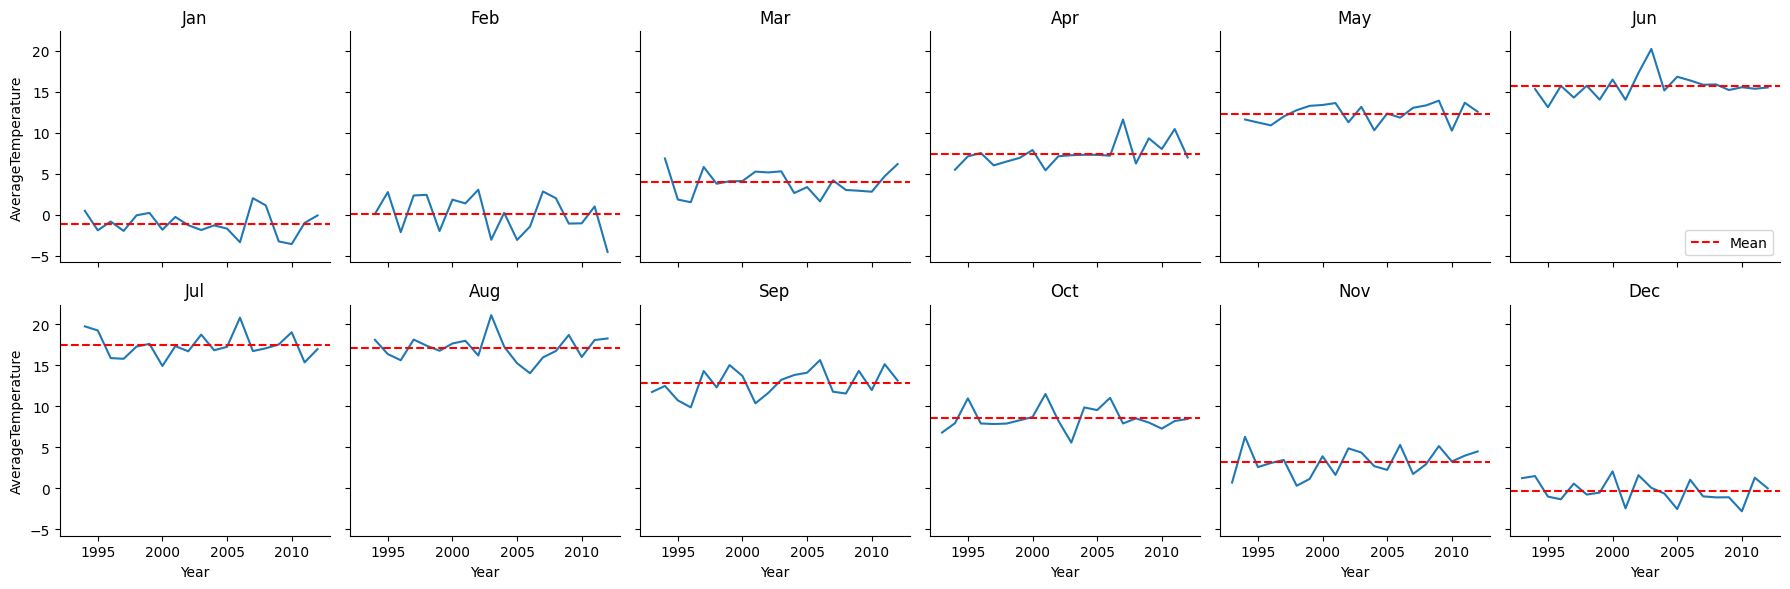

In [11]:
fig = plt.figure(figsize=(12, 6))
g = sns.relplot(data=df, x='Year', y='AverageTemperature', kind='line', col='Month', col_wrap=6, facet_kws={'sharey': True}, height=3)
for month_idx, (ax, month_name) in enumerate(zip(g.axes.flat, months)):
    mean_value = df.loc[df['Month']==month_idx+1, 'AverageTemperature'].mean()
    ax.axhline(mean_value, color='red', linestyle='--', linewidth=1.5, label='Mean')
    ax.set_title(month_name)
    if month_idx == 5:
        ax.legend(loc='lower right')
fig.suptitle('Seasonal Subseries Plot: Monthly Average Temperature in Switzerland', y=1)
g.tight_layout()

### Lag Plot

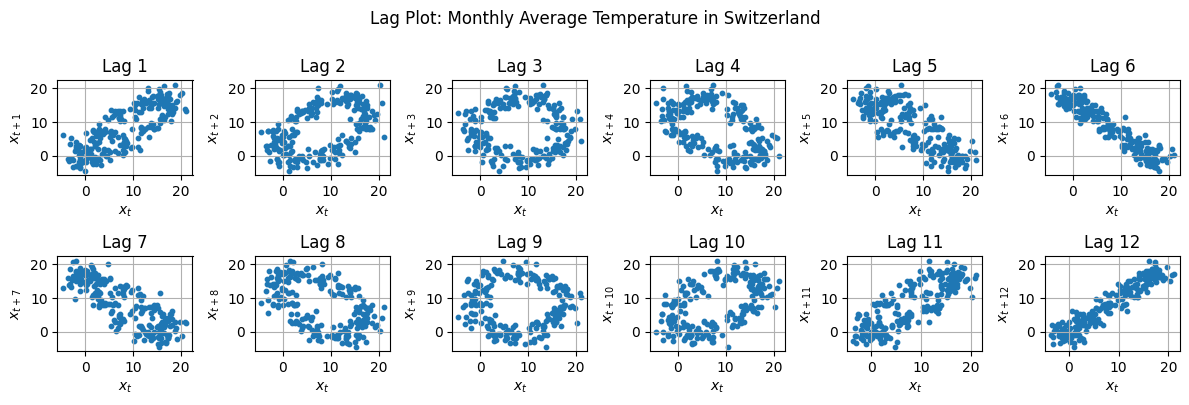

In [12]:
fig, axs = get_figure(nrows=2, ncols=6)
for ax, lag in zip(axs, range(1, 13)):
    ax.scatter(df['AverageTemperature'][:-lag], df['AverageTemperature'][lag:], s=10)
    ax.set_title(f'Lag {lag}')
    ax.set_xlabel('$x_t$')
    ax.set_ylabel(f'$x_{{t+{lag}}}$')
fig.suptitle('Lag Plot: Monthly Average Temperature in Switzerland', y=1)
fig.tight_layout()